### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [7]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_jsma(model, test_loader):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        target = 3
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            

            
            advimages = jsma_attack(model, image, 3, 10)
            output_adv, _ = model(advimages)
            advimages = advimages[0,:,:,:] / 255

            #print(advimages.shape)
            #viz.show(advimages.detach())
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later

                    #if prediction_adv not in pred_list:
                adv_ex = advimages.squeeze().detach().cpu().numpy()

                adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                pred_list.append(prediction_adv)
                    
                        
            total +=1 
            print(correct, "/", total)  
            
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return adv_examples


Attack Image & Predicted Label


In [8]:
adv_examples = test_jsma(mnist_resnet_model, test_loader_mnist)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
1 / 19
1 / 20
1 / 21
1 / 22
1 / 23
1 / 24
1 / 25
1 / 26
1 / 27
1 / 28
1 / 29
1 / 30
2 / 31
2 / 32
3 / 33
3 / 34
3 / 35
3 / 36
3 / 37
3 / 38
3 / 39
3 / 40
3 / 41
3 / 42
3 / 43
3 / 44
4 / 45
4 / 46
4 / 47
4 / 48
4 / 49
4 / 50
4 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
5 / 62
5 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
8 / 77
8 / 78
8 / 79
8 / 80
8 / 81
8 / 82
8 / 83
8 / 84
8 / 85
8 / 86
8 / 87
9 / 88
9 / 89
9 / 90
10 / 91
10 / 92
10 / 93
11 / 94
11 / 95
11 / 96
11 / 97
11 / 98
11 / 99
11 / 100
11 / 101
11 / 102
11 / 103
11 / 104
11 / 105
11 / 106
11 / 107
11 / 108
11 / 109
11 / 110
11 / 111
11 / 112
12 / 113
12 / 114
12 / 115
12 / 116
12 / 117
12 / 118
12 / 119
12 / 120
12 / 121
12 / 122
12 / 123
12 / 124
12 / 125
12 / 126
12 / 127
12 / 128
12 / 129
12 / 130
12 / 131
12 / 132
12 / 133
1

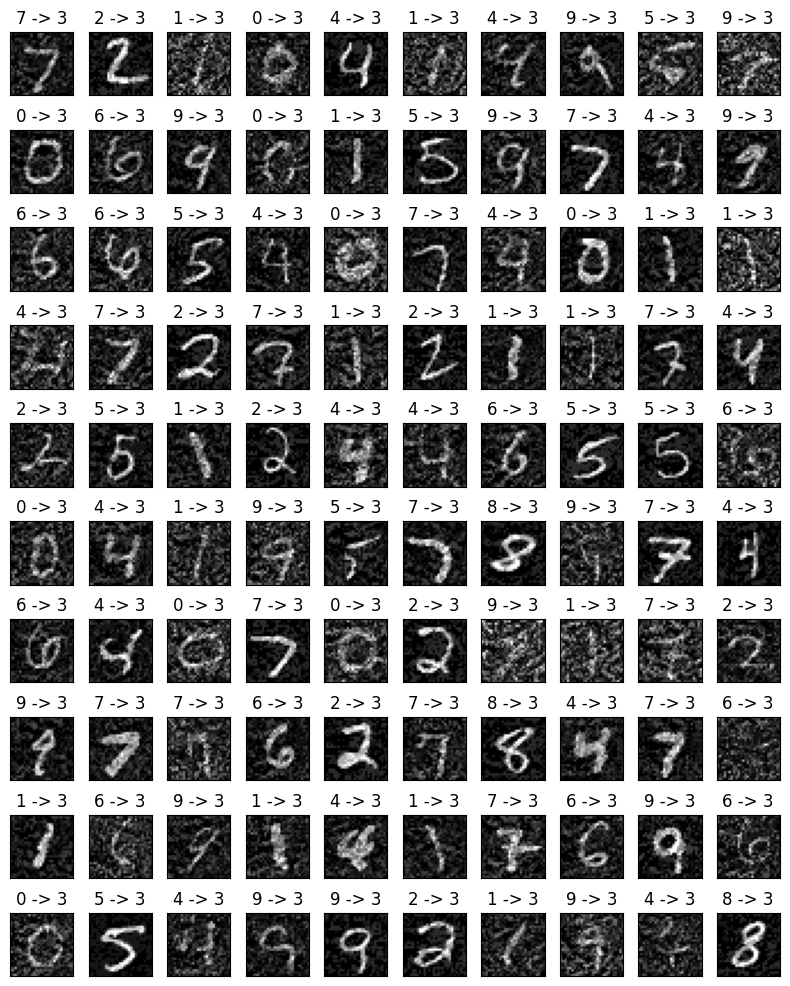

In [9]:
# num_cols = len(adv_examples)
# print(num_cols)

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [10]:
adv_examples = test_jsma(svhn_resnet_model, test_loader_svhn)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
1 / 11
1 / 12
1 / 13
1 / 14
1 / 15
1 / 16
1 / 17
1 / 18
2 / 19
2 / 20
2 / 21
2 / 22
2 / 23
3 / 24
3 / 25
3 / 26
3 / 27
3 / 28
3 / 29
3 / 30
3 / 31
4 / 32
4 / 33
4 / 34
4 / 35
4 / 36
4 / 37
4 / 38
4 / 39
4 / 40
4 / 41
4 / 42
4 / 43
4 / 44
4 / 45
4 / 46
4 / 47
4 / 48
4 / 49
4 / 50
4 / 51
4 / 52
4 / 53
4 / 54
4 / 55
4 / 56
4 / 57
4 / 58
4 / 59
4 / 60
4 / 61
4 / 62
4 / 63
4 / 64
4 / 65
4 / 66
4 / 67
4 / 68
5 / 69
5 / 70
6 / 71
6 / 72
6 / 73
6 / 74
6 / 75
6 / 76
6 / 77
6 / 78
7 / 79
7 / 80
7 / 81
7 / 82
7 / 83
7 / 84
7 / 85
7 / 86
7 / 87
7 / 88
7 / 89
7 / 90
7 / 91
7 / 92
7 / 93
7 / 94
7 / 95
7 / 96
7 / 97
7 / 98
7 / 99
7 / 100
7 / 101
7 / 102
7 / 103
8 / 104
8 / 105
8 / 106
9 / 107
9 / 108
9 / 109
9 / 110
10 / 111
10 / 112
10 / 113
11 / 114
11 / 115
11 / 116
11 / 117
11 / 118
11 / 119
11 / 120
11 / 121
11 / 122
11 / 123
11 / 124
11 / 125
11 / 126
12 / 127
12 / 128
12 / 129
12 / 130
12 / 131
12 / 132
12 / 133
12 / 134
12 / 135
12 

[[[0.00176086 0.00177624 0.00177624 ... 0.00102268 0.00103806 0.00177624]
  [0.00099193 0.00177624 0.00099193 ... 0.00102268 0.00105344 0.00099193]
  [0.00019223 0.00017686 0.00039216 ... 0.         0.         0.00020761]
  ...
  [0.00119185 0.00120723 0.00039216 ... 0.         0.         0.        ]
  [0.00039216 0.00117647 0.00039216 ... 0.         0.         0.00025375]
  [0.00113033 0.00039216 0.00039216 ... 0.         0.         0.00025375]]

 [[0.00197616 0.00277586 0.00277586 ... 0.00196078 0.00119185 0.00109958]
  [0.00277586 0.00277586 0.00277586 ... 0.00196078 0.00116109 0.0026682 ]
  [0.00122261 0.00199154 0.00123799 ... 0.00116109 0.00193003 0.00188389]
  ...
  [0.00222222 0.00145329 0.00142253 ... 0.00063822 0.00062284 0.00136102]
  [0.00297578 0.00142253 0.00139177 ... 0.00062284 0.00139177 0.00056132]
  [0.00216071 0.00216071 0.00134564 ... 0.00139177 0.00059208 0.00056132]]

 [[0.00209919 0.00211457 0.00212995 ... 0.00133026 0.00212995 0.00205306]
  [0.00211457 0.001330

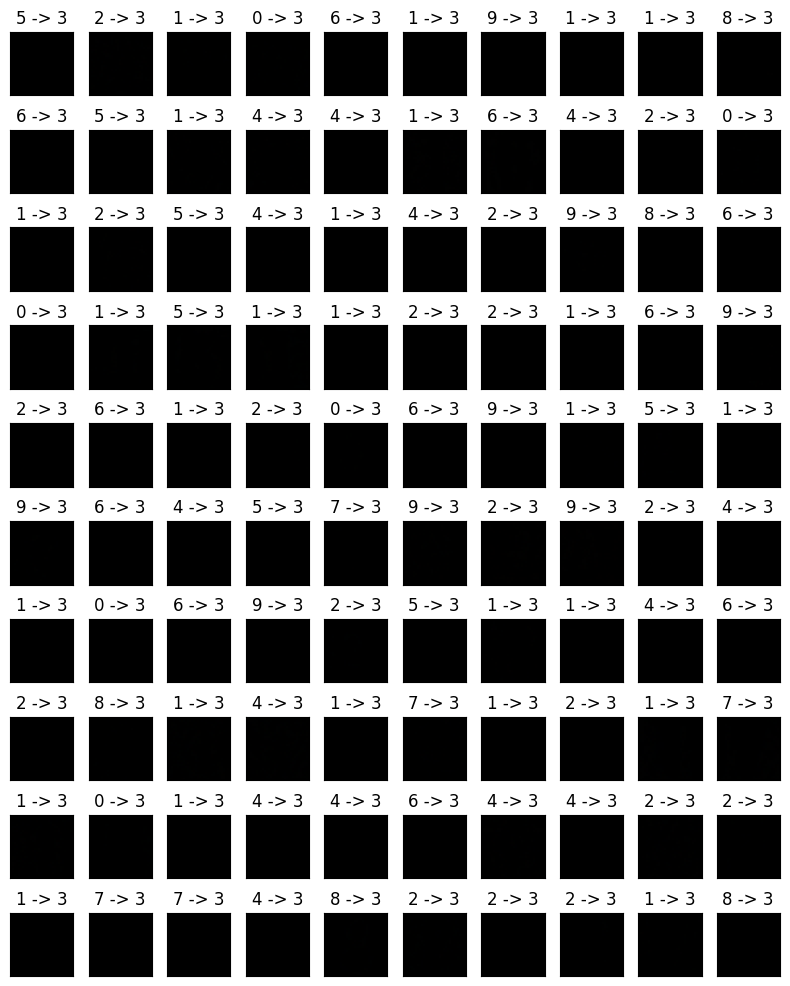

In [11]:
# Test visualizer with an image available in test data
viz = Visualizer()
label_mapping2 = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

print(adv_examples[0][2])

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()